In [1]:
import pandas as pd
from astropy.table import Table 
import matplotlib.pyplot as plt
import numpy as np
import h5py
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from scipy.optimize import curve_fit


/Users/lspina/anaconda2/envs/py36/lib/python3.6/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/Users/lspina/anaconda2/envs/py36/lib/python3.6/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Upload tables and datasets.

In [8]:
path_tables = '/Users/lspina/Projects/Clusters_surveys/membership_analysis/tables/'
data_abu = Table.read(path_tables+'GALAH_DR3_main_200604_clean.fits', format='fits', character_as_bytes=False).to_pandas()
data_Lz = Table.read('GALAH_iDR3_VAC_dynamics_190529.fits', format='fits', character_as_bytes=False).to_pandas()

data_merg = pd.merge(data_abu,data_Lz, on='sobject_id', how='inner')

sel_spec = (data_merg.flag_sp == 0) & (data_merg.snr_c2_iraf > 60)  & (data_merg.flag_fe_h == 0) 
sel = sel_spec

data = data_merg[sel]
print(len(data))

69430


In [10]:
sel_flags = (data.flag_Mg_fe == 0) & (data.flag_Al_fe == 0) & (data.flag_Ba_fe == 0) & (data.flag_Y_fe == 0) & (data.flag_O_fe == 0) & (data.flag_Ti_fe == 0) & (data.flag_Si_fe == 0) & (data.flag_Na_fe == 0)
sel_elem = ~np.isnan(data.fe_h) & ~np.isnan(data.Mg_fe) & ~np.isnan(data.Al_fe) & ~np.isnan(data.Ba_fe) & ~np.isnan(data.Y_fe) & ~np.isnan(data.O_fe) & ~np.isnan(data.Ti_fe) & ~np.isnan(data.Si_fe) & ~np.isnan(data.Na_fe)


sel_TO = (data.logg > 3.0) & (data.logg < 4.0) & (data.teff < 7000) & (data.teff > 4000)
sel_ages = (data.age > 1.)
sel = sel_flags & sel_elem & sel_TO & sel_ages# & ~sel_ages_alpha


features = pd.DataFrame(data=data[col_features][sel])
target = pd.DataFrame(data=data[col_target][sel])
print(len(features))
print(len(target))

11963
11963


### Select features and target variable for the regression.

In [12]:
#col_features = ['fe_h', 'Mg_fe', 'Al_fe', 'Y_fe', 'Ba_fe']
#col_features = ['fe_h', 'Mg_fe', 'Al_fe', 'Ba_fe', 'Y_fe', 'O_fe', 'Si_fe', 'Na_fe']
col_features = ['fe_h', 'Mg_fe', 'Ba_fe', 'Y_fe', 'O_fe', 'Na_fe', 'Ti_fe']

col_target = ['age']

### Training and test datasets

In [13]:
data_dmatrix = xgb.DMatrix(data=features ,label=target)
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.7, test_size=0.2, random_state=42)


### Tune XGBoost hyperparameters

In [14]:
params = {
            'objective':'reg:squarederror',
            'max_depth': 4, #start from 3 and increase of 1
            'learning_rate': 0.04, #values between 0.1 and 0.01
            'colsample_bytree': 1.0, #0.3-0.8 if you have many features; 0.8-1 if you have a few features
            'subsample': 0.8,
            'alpha': 5,
            'gamma':1, #either 0, 1 or 5
            'n_estimators':300
        }         



xg_reg = xgb.XGBRegressor(**params)
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["rmse"]
%time xg_reg.fit(X_train,y_train, eval_metric=eval_metric, eval_set=eval_set)


[0]	validation_0-rmse:5.83429	validation_1-rmse:5.86846
[1]	validation_0-rmse:5.62369	validation_1-rmse:5.66065
[2]	validation_0-rmse:5.42296	validation_1-rmse:5.46286
[3]	validation_0-rmse:5.23055	validation_1-rmse:5.27350
[4]	validation_0-rmse:5.04701	validation_1-rmse:5.09325
[5]	validation_0-rmse:4.87050	validation_1-rmse:4.91988
[6]	validation_0-rmse:4.70263	validation_1-rmse:4.75394
[7]	validation_0-rmse:4.54170	validation_1-rmse:4.59656
[8]	validation_0-rmse:4.38670	validation_1-rmse:4.44424
[9]	validation_0-rmse:4.23957	validation_1-rmse:4.29921
[10]	validation_0-rmse:4.09865	validation_1-rmse:4.16198
[11]	validation_0-rmse:3.96477	validation_1-rmse:4.02997
[12]	validation_0-rmse:3.83644	validation_1-rmse:3.90417
[13]	validation_0-rmse:3.71380	validation_1-rmse:3.78299
[14]	validation_0-rmse:3.59644	validation_1-rmse:3.66725
[15]	validation_0-rmse:3.48450	validation_1-rmse:3.55656
[16]	validation_0-rmse:3.37882	validation_1-rmse:3.45351
[17]	validation_0-rmse:3.27735	validation

[144]	validation_0-rmse:1.38170	validation_1-rmse:1.53769
[145]	validation_0-rmse:1.38060	validation_1-rmse:1.53737
[146]	validation_0-rmse:1.37998	validation_1-rmse:1.53712
[147]	validation_0-rmse:1.37939	validation_1-rmse:1.53669
[148]	validation_0-rmse:1.37873	validation_1-rmse:1.53636
[149]	validation_0-rmse:1.37779	validation_1-rmse:1.53597
[150]	validation_0-rmse:1.37719	validation_1-rmse:1.53546
[151]	validation_0-rmse:1.37605	validation_1-rmse:1.53499
[152]	validation_0-rmse:1.37487	validation_1-rmse:1.53404
[153]	validation_0-rmse:1.37414	validation_1-rmse:1.53347
[154]	validation_0-rmse:1.37357	validation_1-rmse:1.53328
[155]	validation_0-rmse:1.37278	validation_1-rmse:1.53300
[156]	validation_0-rmse:1.37169	validation_1-rmse:1.53281
[157]	validation_0-rmse:1.37093	validation_1-rmse:1.53240
[158]	validation_0-rmse:1.37022	validation_1-rmse:1.53205
[159]	validation_0-rmse:1.36970	validation_1-rmse:1.53158
[160]	validation_0-rmse:1.36900	validation_1-rmse:1.53127
[161]	validati

[286]	validation_0-rmse:1.29966	validation_1-rmse:1.51532
[287]	validation_0-rmse:1.29913	validation_1-rmse:1.51525
[288]	validation_0-rmse:1.29871	validation_1-rmse:1.51537
[289]	validation_0-rmse:1.29849	validation_1-rmse:1.51555
[290]	validation_0-rmse:1.29820	validation_1-rmse:1.51569
[291]	validation_0-rmse:1.29786	validation_1-rmse:1.51556
[292]	validation_0-rmse:1.29738	validation_1-rmse:1.51538
[293]	validation_0-rmse:1.29694	validation_1-rmse:1.51558
[294]	validation_0-rmse:1.29654	validation_1-rmse:1.51569
[295]	validation_0-rmse:1.29605	validation_1-rmse:1.51542
[296]	validation_0-rmse:1.29551	validation_1-rmse:1.51528
[297]	validation_0-rmse:1.29531	validation_1-rmse:1.51530
[298]	validation_0-rmse:1.29494	validation_1-rmse:1.51507
[299]	validation_0-rmse:1.29469	validation_1-rmse:1.51485
CPU times: user 5.47 s, sys: 299 ms, total: 5.77 s
Wall time: 2.6 s


XGBRegressor(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.04, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=5, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

Train: 1.29469; Test:1.514854


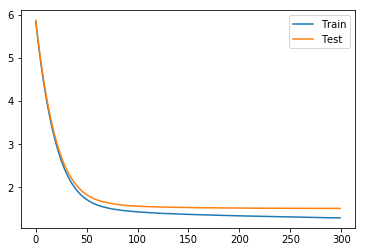

In [15]:
print('Train: {}; Test:{}'.format(xg_reg.evals_result_['validation_0']['rmse'][-1],xg_reg.evals_result_['validation_1']['rmse'][-1]))
plt.plot(xg_reg.evals_result_['validation_0']['rmse'], label='Train')
plt.plot(xg_reg.evals_result_['validation_1']['rmse'], label='Test')
plt.legend()
plt.show()


### Feature importance

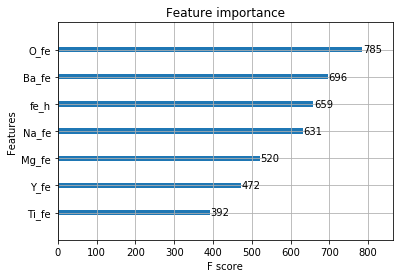

<Figure size 1152x864 with 0 Axes>

In [16]:
xgb.plot_importance(xg_reg)
plt.figure(figsize = (16, 12))
plt.show()

### Metrics

In [17]:
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))


RMSE: 1.514854


### Results

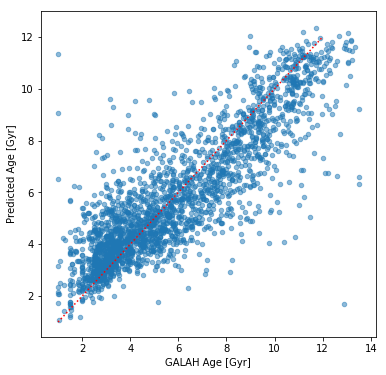

In [18]:
plt.figure(figsize=(6,6))
x = np.linspace(1,12)
plt.plot(x,x,'r:')
plt.scatter(y_test,preds, s=20, alpha=0.5)
plt.xlabel("GALAH Age [Gyr]")
plt.ylabel("Predicted Age [Gyr]")
plt.show()